In [1]:

from tensorflow import keras
import tensorflow as tf
import cv2
import math
import os
import sys  
sys.path.insert(0, 'G:\\My Drive\\Colab Notebooks\\MWCNN')
import models.DWT2


In [2]:
# load image convert to grey
img_in = cv2.imread("../input/Lenna_Orig.png")
img_grey_in = cv2.cvtColor(img_in, cv2.COLOR_RGB2GRAY)

In [3]:
# expand asxis to look like x_train data
img_grey = tf.expand_dims(img_grey_in, axis=0)
img_grey = tf.expand_dims(img_grey, axis=-1)

In [4]:
# load DWT db2 model
model = keras.Sequential()
model.add(keras.Input(shape=(512, 512, 1)))
model.add(models.DWT2.DWT())
# model.add(models.DWT2.IDWT())
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dwt (DWT)                    (None, 256, 256, 4)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [5]:
coeffs = model.predict(img_grey,steps=1)


In [6]:
coeffs.shape

(1, 256, 256, 4)

In [7]:
x = tf.pad(coeffs, [[0, 0], [3, 3], [3, 3], [0, 0]], "SYMMETRIC")
x = tf.cast(x, tf.float32)

In [8]:
# calc db2 coefs
db2_h0 = (1+math.sqrt(3))/(4*math.sqrt(2))
db2_h1 = (3+math.sqrt(3))/(4*math.sqrt(2))
db2_h2 = (3-math.sqrt(3))/(4*math.sqrt(2))
db2_h3 = (1-math.sqrt(3))/(4*math.sqrt(2))

# Reconstruction LPF and HPF
db2_lpfR = [db2_h3, db2_h2, db2_h1, db2_h0]
db2_hpfR = [-db2_h0, db2_h1, -db2_h2, db2_h3]
print(db2_lpfR)
print(db2_hpfR)
# convert to matrix for conv2d
db2_lpf = tf.constant(db2_lpfR)
db2_lpf = tf.reshape(db2_lpf, (1, 4, 1, 1))
# db2_lpf = tf.repeat(db2_lpf, 4, axis=-1)

db2_hpf = tf.constant(db2_hpfR)
db2_hpf = tf.reshape(db2_hpf, (1, 4, 1, 1))
# db2_hpf = tf.repeat(db2_hpf, 4, axis=-1)

[-0.12940952255126034, 0.2241438680420134, 0.8365163037378077, 0.4829629131445341]
[-0.4829629131445341, 0.8365163037378077, -0.2241438680420134, -0.12940952255126034]


In [9]:
LL = tf.expand_dims(x[:,:,:,0], axis=-1)
LH = tf.expand_dims(x[:,:,:,1], axis=-1)
HL = tf.expand_dims(x[:,:,:,2], axis=-1)
HH = tf.expand_dims(x[:,:,:,3], axis=-1)

In [10]:

def upsampler(x):
    zero_tensor = tf.zeros(shape=x.shape, dtype=tf.float32)
    stack_rows = tf.stack([x, zero_tensor], axis=3)
    stack_rows = tf.reshape(stack_rows, shape=[x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3]])
    stack_rows = tf.transpose(stack_rows, perm=[0, 2, 1, 3])
    zero_tensor_1 = tf.zeros(shape=stack_rows.shape, dtype=tf.float32)
    
    stack_rows_cols = tf.stack([stack_rows, zero_tensor_1], axis=3)
    us_padded = tf.reshape(stack_rows_cols, shape=[x.shape[0], x.shape[1]*2, x.shape[2]*2, x.shape[3]])
    
    us_padded = tf.transpose(us_padded, perm=[0, 2, 1, 3])
    return us_padded


LL_us_pad = upsampler(LL)
LH_us_pad = upsampler(LH)
HL_us_pad = upsampler(HL)
HH_us_pad = upsampler(HH)

In [11]:
with tf.Session() as sess:
    print(sess.run(HH_us_pad[0,0,0,0]))

-0.2622565


In [12]:
padd_type = 'VALID'
LL_conv_lpf = tf.nn.conv2d(LL_us_pad, db2_lpf, padding=padd_type, strides=[1, 1, 1, 1],)
LL_conv_lpf_tr = tf.transpose(LL_conv_lpf, perm=[0, 2, 1, 3])
LL_conv_lpf_lpf = tf.nn.conv2d(LL_conv_lpf_tr, db2_lpf, padding=padd_type, strides=[1, 1, 1, 1],)
LL_conv_lpf_lpf_tr = tf.transpose(LL_conv_lpf_lpf, perm=[0, 2, 1, 3])

LH_conv_lpf = tf.nn.conv2d(LH_us_pad, db2_lpf, padding=padd_type, strides=[1, 1, 1, 1],)
LH_conv_lpf_tr = tf.transpose(LH_conv_lpf, perm=[0, 2, 1, 3])
LH_conv_lpf_hpf = tf.nn.conv2d(LH_conv_lpf_tr, db2_hpf, padding=padd_type, strides=[1, 1, 1, 1],)
LH_conv_lpf_hpf_tr = tf.transpose(LH_conv_lpf_hpf, perm=[0, 2, 1, 3])

HL_conv_hpf = tf.nn.conv2d(HL_us_pad, db2_hpf, padding=padd_type, strides=[1, 1, 1, 1],)
HL_conv_hpf_tr = tf.transpose(HL_conv_hpf, perm=[0, 2, 1, 3])
HL_conv_hpf_lpf = tf.nn.conv2d(HL_conv_hpf_tr, db2_lpf, padding=padd_type, strides=[1, 1, 1, 1],)
HL_conv_hpf_lpf_tr = tf.transpose(HL_conv_hpf_lpf, perm=[0, 2, 1, 3])

HH_conv_hpf = tf.nn.conv2d(HH_us_pad, db2_hpf, padding=padd_type, strides=[1, 1, 1, 1],)
HH_conv_hpf_tr = tf.transpose(HH_conv_hpf, perm=[0, 2, 1, 3])
HH_conv_hpf_hpf = tf.nn.conv2d(HH_conv_hpf_tr, db2_hpf, padding=padd_type, strides=[1, 1, 1, 1],)
HH_conv_hpf_hpf_tr = tf.transpose(HH_conv_hpf_hpf, perm=[0, 2, 1, 3])



In [13]:
with tf.Session() as sess:
    print(sess.run(LL_conv_lpf_lpf_tr[0,2,1,0]))

144.1005


In [14]:
LL_LH = tf.math.add(LL_conv_lpf_lpf_tr, LH_conv_lpf_hpf_tr)
HL_HH = tf.math.add(HL_conv_hpf_lpf_tr, HH_conv_hpf_hpf_tr)

In [15]:
res = tf.math.add(LL_LH,HL_HH)

In [16]:
# with tf.Session() as sess:
#     res_img = sess.run(res)
#     print(res_img[0,0,:,0])

In [18]:

img_out_tensor = tf.image.convert_image_dtype(res[0, ..., 0], dtype=tf.float32)

In [19]:
with tf.Session() as sess:
    img_out = sess.run(img_out_tensor)
    

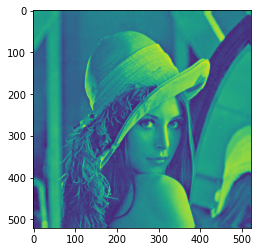

(521, 521)

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img_out)
plt.show()
img_out.shape

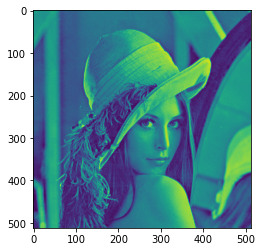

(512, 512)

In [21]:
plt.imshow(img_grey_in)
plt.show()
img_grey_in.shape

In [22]:
# in_t = tf.constant([[1,2,3],[4,5,6],[7,8,9]], dtype=tf.float32)
# in_t = tf.expand_dims(in_t, axis=-1)
# in_t = tf.expand_dims(in_t, axis=0)
# print(in_t.shape)
# zero_tensor = tf.zeros(shape=(1,3,3,1), dtype=tf.float32)
# c = tf.stack([in_t, zero_tensor], axis=3)
# res = tf.reshape(c, shape=[1,3,6,1])
# res.shape

# zero_tensor1 = tf.zeros(shape=(1,3,6,1), dtype=tf.float32)
# ca = tf.stack([res, zero_tensor1], axis=2)

# res1 = tf.reshape(ca, shape=[1,6,6,1])
# print(res1.shape)
# with tf.Session() as sess:
#     print(sess.run(res1))

In [23]:
img_grey_in-img_out[5:-4,5:-4]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -2.2436539e+01, -3.8861221e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.5258789e-05, -2.2436539e+01, -3.8861237e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.5258789e-05, -2.2436523e+01, -3.8861221e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.6293945e-06, -3.4641113e+00, -6.0000076e+00],
       [-6.6989899e-02, -6.6989899e-02,  2.9820480e+00, ...,
        -1.5490417e+00,  2.3815689e+00,  3.6740341e+00],
       [-1.1602783e-01, -1.1602783e-01,  5.1650620e+00, ...,
        -2.6830139e+00,  1.9419785e+00,  2.5825195e+00]], dtype=float32)

In [24]:
# x = tf.constant([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
# indices = tf.constant([[0]] )

# # shape = tf.constant()
# scatter = tf.scatter_nd(indices, x, [3,4])
# print(scatter)
# with tf.Session() as sess:
# #     print(sess.run(x))
#     print(sess.run(scatter))
#     print(sess.run(indices))